In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# настроим seaborn и установим стиль whitegrid
sns.set(style='whitegrid')

In [2]:
customers_df = pd.read_csv('olist_customers_dataset.csv')

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (в идеальных данных не может быть двух пользователей с одинаковым значением, является уникальным айдишником пользователя)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [3]:
order_items_df = pd.read_csv('olist_order_items_dataset.csv')

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа (не содержит информацию о количестве товаров)

product_id —  уникальный идентефикатор товара (аналог штрихкода)

seller_id — уникальный идентефикатор производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [4]:
orders_df = pd.read_csv('olist_orders_dataset.csv')

olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

# Посмотрим форму таблицы, типы данных и есть ли пропущенные значения

In [5]:
# таблица customers_df
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
# таблица order_items_df
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [7]:
# таблица orders_df
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [8]:
# пропущенные значения есть только в одной таблице
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [9]:
# посмотрим, на количество заказов в разбивке по статусам
orders_df.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [10]:
# так как у нас есть колонки с датой, но у них тип данных object
# лучше сразу поменяем тип данных на дату, чтобы легче было работать с этими столбцами
orders_df = orders_df.astype({'order_purchase_timestamp': 'datetime64',
                     'order_approved_at': 'datetime64',
                     'order_delivered_carrier_date': 'datetime64',
                     'order_delivered_customer_date': 'datetime64',
                     'order_estimated_delivery_date': 'datetime64'})

In [11]:
orders_df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

# Предварительное исследование данных

Чтобы понять, с каким статусом заказ будет считаться покупкой, необходимо определить, когда переходит право собственности на товар. Покупка означает вступление во владение данным активом, собственностью, предметом или правом, заплатив заранее определенную сумму денег для успешного завершения транзакции. При доставке право собственности переходит в момент вручения товара покупателю или указанному им лицу. Таким образом, до того, как товар будет передан клиенту, владеет и несет ответственность за него компания. Значит в определении понятия покупка, совершенная клиентом, нам подойдут только те заказы, которые уже переданы пользователю, то есть со статусом delivered(доставлен).

Моментом продажи для компании можно считать то, когда пользователь фактически оплатил заказ. Именно в этот момент единица товара становится недоступна для других, так как одну единицу товара два раза продать не получится.

Уникальные статусы заказов в таблице orders_df:

Есть такие уникальные заказы, как created —  создан, approved —  подтверждён, invoiced —  выставлен счёт, processing —  в процессе сборки заказа, shipped —  отгружен со склада.

delivered —  доставлен пользователю. В данных есть заказы(14 штук) со статусом delivered(доставлен), но нет даты оплаты. Будем считать, что это ошибка в данных и дата просто не загрузилась. Так же в заказах со статусом delivered есть заказы(8 штук), у которых нет даты доставки, хотя по статусу знаем, что клиенту товар был доставлен. Будем считать, что это тоже просто ошибка в данных.

unavailable —  недоступен. Это означает, что товар не доступен(к примеру, его нет на складе) и пользователь не сможет получить заказ, следовательно ему вернут потраченные средства, если он оплатил.

canceled —  отменён. Все заказы со статусом canceled(отмененные) не считаем покупкой, совершенной пользователем, даже если оплата была произведена(в данных есть заказы, которые отменены,  но оплачены) или были доставлены(есть заказы, которые были доставлены, но отменены, скорее всего не понравилось качество товара или не вовремя доставили), так как пользователь отказался от заказа и ему будут возвращены деньги.

посмотрим на заказы со статусом delivered(14 штук), у которых нет даты оплаты

In [66]:
# найдем эти 14 заказов, где есть статус delivered(доставлен), но нет даты оплаты.
# можно заметить, что очень много заказов(8 штук) было сделано 2017-02-18(колонка order_purchase_timestamp)
# и еще 3 заказа за день до этого и 1 после
# явно есть какая-то взаимосвязь, скорее всего в этот день плохо работал сайт или по какой-то другой причине не внеслась дата
# но так как заказы были доставлены пользователю, оставим эти данные и не будем их удалять
orders_df[orders_df['order_approved_at'].isna()].query('order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


посмотрим на заказы со статусом delivered(8 штук), у которых нет даты доставки

In [67]:
# можем предположить, что клиент лично забрал товар и не воспользовался доставкой
# так как можно заметить, что сделан заказ и оплачен в один день, и они отличаются примерно на 20 минут
# но точно мы сказать не можем, может это просто ошибка в данных
orders_df[orders_df.order_delivered_customer_date.isna()].query('order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


посмотрим на заказы со статусом canceled(6 штук), у которых есть дата доставки

In [70]:
# можем предположить, что товар был доставлен клиенту, поэтому есть дата доставки
# но клиенту не понравилось качество товара(к примеру, может что-то сломано было) и он отказался от заказа и отменил его
# может, слишком поздно доставили или достака была просто не вовремя, что тоже могло повлиять на то, что клиент отказался
orders_df.query('order_status == "canceled"').dropna(subset=['order_delivered_customer_date'])

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


# Сколько у нас пользователей, которые совершили покупку только один раз?

Необходимо найти то, когда пользователь совершил одну покупку только один раз. Покупкой можно называть то, когда приобретают один товар, а покупками можно считать, когда приобретают больше чем один товар. Значит, в начале необходимо отобрать те чеки, в которых есть только одна покупка.

In [12]:
# данные по чекам находятся в таблице order_items_df
# сгруппируем по чекам, посчитаем количество купленных товаров и отберем те чеки, где только одна покупка
orders_with_one_purchase = order_items_df \
                            .groupby('order_id', as_index=False) \
                            .agg({'product_id': 'count'}) \
                            .rename(columns={'product_id': 'quantity'}) \
                            .query('quantity == 1')

Далее нам необходимо объеденить несколько таблиц, так как надо связать чеки с пользователями. В начале объединим полученную таблицу orders_with_one_purchase по номеру чека с таблицей orders_df, в которой находятся данные по позаказному идентификатору пользователя. Далее, по этому позаказному идентификатору пользователя свяжем объединенную таблицу с customers_df. Тем самым получим таблицу, где каждому пользователю будет соотносится сделанный заказ на одну покупку.

In [13]:
# объединим orders_with_one_purchase с orders_df
# не будем брать по всем столбцам, а возьмем только нужные
# из таблицы orders_with_one_purchase возьмем позаказный номер
# из таблицы orders_df возьмем номер заказа, позаказный номер, статус и дату оплаты(доставки!!!)
# по умолчанию в merge тип объединения inner
orders_with_one_purchase = pd.merge(orders_with_one_purchase['order_id'],
                                      orders_df[['order_id', 'customer_id', 'order_status']],
                                      on='order_id')

In [14]:
# объединим customers_with_one_purchase с customers_df
# не будем брать по всем столбцам, а возьмем только нужные
# из таблицы customers_df возьмем позаказный номер и уникальный номер пользователя
# по умолчанию в merge тип объединения inner
orders_with_one_purchase = pd.merge(orders_with_one_purchase,
                                      customers_df[['customer_id', 'customer_unique_id']],
                                      on='customer_id')

Чтобы понять, с каким статусом заказ будет считаться покупкой, необходимо определить, когда переходит право собственности на товар. Покупка означает вступление во владение данным активом, собственностью, предметом или правом, заплатив заранее определенную сумму денег для успешного завершения транзакции. При доставке право собственности переходит в момент вручения товара покупателю или указанному им лицу. Таким образом, до того, как товар будет передан клиенту, владеет и несет ответственность за него компания. Значит нам подойдут только те заказы, которые уже переданы пользователю, то есть со статусом delivered(доставлен).

In [15]:
# а теперь сгруппируем данные, посчитаем количество покупок
# и отберем тех пользователей, которые совершили одну покупку только один раз
customers_with_one_purchase = orders_with_one_purchase \
                                .query('order_status == "delivered"') \
                                .groupby('customer_unique_id', as_index=False) \
                                .agg({'order_id': 'count'}) \
                                .query('order_id == 1') \
                                .shape[0]
print(f'Вывод: {customers_with_one_purchase} пользователь совершил покупку только один раз')

Вывод: 82251 пользователь совершил покупку только один раз


# Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Заказ не считается доставленным, если нет времени доставки заказа пользователю, данные которого хранятся в колонке order_delivered_customer_date. 

Так как будем смотреть не доставленные заказы по разным причинам, то будем использовать дату из колонки order_purchase_timestamp(время создание заказа). Это дата, когда пользователь создал заказ и если в дальнейшем он не был доставлен, не важно по какой причине, то такие данные будут нам интересны для исследования.

In [16]:
# оставим только те заказы, у которых нет времени доставки пользователю и сохраним таблицу в новую переменную
orders_without_deliver = orders_df[orders_df['order_delivered_customer_date'].isna()]

In [17]:
# проверим, заказы с какими статусами не доставлялись
# можно заметить, что есть заказы со статусом delivered(доставлен)
# если заказ доставлен и нет даты, значит ощибка в данных, такие заказы будем считать доставлеными до пользователя
orders_without_deliver.order_status.value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

In [18]:
# отфильтруем таблицу, убрав заказы со статусом delivered
orders_without_deliver = orders_without_deliver.query('order_status != "delivered"')

In [19]:
# чтобы удобнее было работать с данными, создадим новую колонку, куда поместим год и месяц
# чтобы в дальнейшем посчитать уникальное количество месяцев
orders_without_deliver['year_month'] = orders_without_deliver['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [20]:
# найдем общее среднее количество недоставленных заказов за эти месяцы
# сгруппируем по колонке year_month, посчитаем количество заказов в этих месяцах и посчитаем среднее через метод mean()
# округлим среднее до целого
not_delivered_mean = orders_without_deliver.shape[0] / orders_without_deliver.year_month.nunique()
print(f'Вывод: {round(not_delivered_mean)} заказа в месяц в среднем не доставляется')

Вывод: 123 заказа в месяц в среднем не доставляется


In [21]:
# далее выведем детализацию по причинам, то есть узнаем общее количество недоставленных заказов по разным статусам
# а также найдем сколько заказов в месяц в среднем не доставляется по разным причинам
# отсортируем по убыванию и проставим индексы по порядку
mean_by_status = orders_without_deliver \
                .groupby('order_status', as_index=False) \
                .agg({'customer_id': 'count'}) \
                .rename(columns={'customer_id': 'quantity'}) \
                .sort_values('quantity', ascending=False) \
                .reset_index(drop=True)

In [22]:
# найдем среднее, разделив общее количество недоставленных заказов по разным статусам на количество исследуемых месяцев
# округлим результат среднего до двух знаков после запятой
mean_by_status['mean_by_status'] = round(mean_by_status.quantity / orders_without_deliver.year_month.nunique(), 2)

In [23]:
# колонка с количеством недоставленных товаров нам больше не нужна, так как нам необходимо найти только среднюю
# поэтому удалим столбец quantity
mean_by_status = mean_by_status.drop('quantity', axis=1)

In [24]:
# так мы получили таблицу с детализацией причин заказов по месяцам, которые в среднем не доставляются по разным причинам
mean_by_status

,order_status,mean_by_status
0,shipped,46.12
1,canceled,25.79
2,unavailable,25.38
3,invoiced,13.08
4,processing,12.54
5,created,0.21
6,approved,0.08


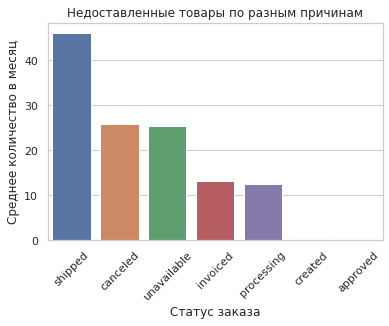

In [25]:
# нарисуем график, где покажем различия в недоставленных товарах по разным причинам
# больше всего недоставленных товаров по причине того, что они отгружены со склада(shipped)
sns.barplot(data=mean_by_status, x='order_status', y='mean_by_status')
plt.title('Недоставленные товары по разным причинам')
plt.xlabel('Статус заказа')
plt.ylabel('Среднее количество в месяц')
plt.xticks(rotation=45);

В итоге можно сделать вывод, что 123 заказа в месяц в среднем не доставляется по разным причинам. Из них больше всего недоставленных товаров по причине того, что они отгружены со склада(shipped).

# По каждому товару определить, в какой день недели товар чаще всего покупается.

Необходимо найти то, в какой день недели товар чаще всего покупается. Значит, смотреть надо со стороны компании, когда товар был продан. Таким образом, товар будет считаться проданным, когда покупатель заплатил за него деньги. Следовательно, день недели продажи будет определяться по дате оплаты(колонка order_approved_at). Именно в этот момент единица товара становится недоступна для других, так как одну единицу товара два раза продать не получится. 

Интересовать будут все заказы, кроме заказов со статусом unavailable(так как они недоступны) и created(заказ только создается). Остальные нам подходят, если есть фактический день оплаты, даже если не были доставлены. Так как на какой-то момент времени они все же были проданы, хоть и застряли в каком-нибудь статусе и дальнейшего движения не было. Например, даже если пользователь в итоге отказался (статус canceled) от товара, то он все же был продан в какой-то день. И для статистики по дням недели нам эти данные подойдут.

In [26]:
# объединим 2 таблицы, order_items_df и orders_df
# возьмем только несколько столбцов, чтобы их не было много и было удобнее
# из таблицы order_items_df возьмем номер заказа и уникальный идентефикатор товара
# из таблицы orders_df возьмем номер заказа, статус и дату оплаты
# по умолчанию в merge тип объединения inner
product_by_day = pd.merge(order_items_df[['order_id', 'product_id']],
                       orders_df[['order_id', 'order_status', 'order_approved_at']],
                       on='order_id')

In [27]:
# перезапишем данные, отфильтруя статусы, которые нам не подходят, так как не считаются покупкой
product_by_day = product_by_day.query('order_status != "created" & order_status != "unavailable"')

In [28]:
# сначала проверим, во всех ли заказах есть дата оплаты
product_by_day.isna().sum()

order_id              0
product_id            0
order_status          0
order_approved_at    15
dtype: int64

In [29]:
# найдем эти 15 заказов без даты оплаты и посмотрим их статус
product_by_day[product_by_day.order_approved_at.isna()].order_status.value_counts()

delivered    15
Name: order_status, dtype: int64

In [30]:
# нам необходимо удалить эти данные без даты оплаты, так как мы не сможем определить, в какой день недели поступила оплата
# для начала посмотрим, сколько всего строк было изначально, чтобы проверить, были ли удалены эти 15 строк
product_by_day.shape[0]

112643

In [31]:
# удаляем строки без дат оплаты, используя dropna и параметр subset, чтобы удалил только по этой колонке
product_by_day = product_by_day.dropna(subset=['order_approved_at'])

In [32]:
# можем убедиться, что сделали все правильно и 15 строк были удалены
product_by_day.shape[0]

112628

In [33]:
# создадим новую колонку и запишем в нее название дня недели, когда была совершена покупка
product_by_day['name_of_day'] = product_by_day.order_approved_at.dt.day_name()

In [34]:
# в переменную сохраним таблицу о том, в какой день недели товар чаще всего покупается
# в начале сгруппировали по айди товара и дням недели, посчитали количество купленных товаров по дням
# отсортировали в порядке убывания, тем самым выше будет находится самый часто покупаемый товар
# далее воспользуемся drop_duplicates с параметром subset='product_id', удалим повторяющиеся значения по колонке product_id
# так как первым вхождением будет день недели, в котором больше всего раз товар был куплен
# остальные повторы по айди товара удалятся, которые с меньшими покупками, чем первое вхождение
# и в конце удалим столбец с количеством заказов, так как мы ищем только дни недели, когда чаще всего покупался товар
product_by_day = product_by_day \
        .groupby(['product_id', 'name_of_day'], as_index=False) \
        .agg({'order_id': 'count'}) \
        .sort_values('order_id', ascending=False) \
        .drop_duplicates(subset='product_id') \
        .drop('order_id', axis=1)

In [35]:
# полученна таблица, в которой хранится информация о том, в какой день недели товар чаще всего покупается
product_by_day

,product_id,name_of_day
41078,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday
20150,53b36df67ebb7c41585e8d54d6772e08,Tuesday
15931,422879e10f46682990de24d770e7f83d,Tuesday
36571,99a4788cb24856965c36a24e339b6058,Tuesday
13058,368c6c730842d78016ad823897a372db,Thursday
...,...,...
23974,63dfa8b12200610ed7b5e41d3c888a25,Saturday
23978,63e51e65ec59b56039c6427eed73dcf0,Tuesday
23979,63eb97106bfe47fe857edcf78f3e3e08,Saturday
23989,63f52009dc3ddb733394e80183aed0f0,Saturday


In [60]:
# теперь выясним, сколько товаров с максимальной продажей по дням недели
product_by_day.name_of_day.value_counts()

Tuesday      6109
Friday       5667
Thursday     4943
Monday       4710
Wednesday    4630
Saturday     4088
Sunday       2795
Name: name_of_day, dtype: int64

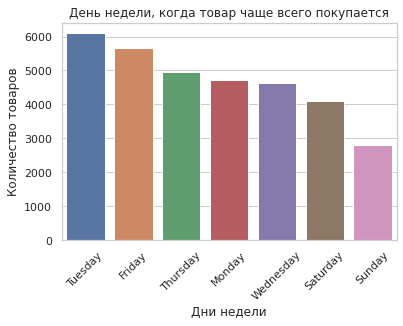

In [36]:
# а теперь нарисуем график и посмотрим, в какие дни недели продается максимальное количество одного товара
# отсортируем график так, чтобы слева был день недели когда больше всего было продано различных товаров
# можно заметить, что во вторник(Tuesday) больше всего продается различное количество товаров с максимальными продажами
sns.countplot(data=product_by_day, x='name_of_day', order=product_by_day['name_of_day'].value_counts().index)
plt.title('День недели, когда товар чаще всего покупается')
plt.xlabel('Дни недели')
plt.ylabel('Количество товаров')
plt.xticks(rotation=45);

В итоге можно сделать вывод, что вторник(Tuesday) является днем недели, когда происходит больше всего максимальных продаж по разным товарам. 6109 товаров с максимальной продажей во вторник.

# Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

Необходимо найти среднее число покупок по пользователям в неделю и по месяцам. Покупка совершается тогда, когда есть факт оплаты и происходит передача прав собственности. При доставке право собственности переходит в момент вручения товара покупателю или указанному им лицу. Следовательно, определять день недели, когда свершился факт покупки, будем по времени даставки заказа клиенту, которое находится в колонке order_delivered_customer_date. Таким образом, нам подойдут заказы только со статусом delivered, так как они фактически оплачены и доставлены. 

В данных есть заказы(14 штук) со статусом delivered(доставлен), но нет даты оплаты. Будем считать, что это ошибка в данных и дата просто не загрузилась. Так как заказы были доставлены пользователю(есть дата доставки), оставим эти данные и не будем их удалять.

Так же в заказах со статусом delivered есть заказы(8 штук), у которых нет даты доставки. Это тоже ошибка в данных, но такие заказы мы не можем учитывать, так как не знаем день доставки до пользователя(в каком месяце или на какой неделе был).

посчитаем количество купленных товаров по каждому чеку

In [39]:
# нужна информация по купленным товарам, данные по чекам находятся в таблице order_items_df
# сгруппируем по чекам, посчитаем количество купленных товаров
purchases_in_orders = order_items_df \
                            .groupby('order_id', as_index=False) \
                            .agg({'product_id': 'count'}) \
                            .rename(columns={'product_id': 'quantity'})
purchases_in_orders

,order_id,quantity
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


Далее нам необходимо объеденить несколько таблиц, так как надо связать чеки с пользователями. В начале объединим полученную таблицу orders_with_one_purchase по номеру чека с таблицей orders_df, в которой находятся данные по позаказному идентификатору пользователя. Далее, по этому позаказному идентификатору пользователя свяжем объединенную таблицу с customers_df. Тем самым получим таблицу, где каждому пользователю будет соотносится сделанный заказ.

In [40]:
# объединим таблицы purchases_in_orders и orders_df, используя только нужные столбцы
# из таблицы orders_df возьмем номер заказа, позаказный номер, статус и дату доставки
# по умолчанию в merge тип объединения inner
purchases_in_orders = pd.merge(purchases_in_orders,
                              orders_df[['order_id', 'customer_id', 'order_status', 'order_delivered_customer_date']],
                              on='order_id')
purchases_in_orders

,order_id,quantity,customer_id,order_status,order_delivered_customer_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,3ce436f183e68e07877b285a838db11a,delivered,2017-09-20 23:43:48
1,00018f77f2f0320c557190d7a144bdd3,1,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-05-12 16:04:24
2,000229ec398224ef6ca0657da4fc703e,1,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-22 13:19:16
3,00024acbcdf0a6daa1e931b038114c75,1,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-14 13:32:39
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-03-01 16:42:31
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-05-10 22:56:40
98662,fffcd46ef2263f404302a634eb57f7eb,1,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-23 20:31:55
98663,fffce4705a9662cd70adb13d4a31832d,1,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-28 12:22:22
98664,fffe18544ffabc95dfada21779c9644f,1,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-16 21:59:40


In [41]:
# зная, что необходимые данные нужны только со статусом delivered, отфильтруем полученную таблицу
purchases_in_orders = purchases_in_orders.query('order_status == "delivered"')

In [42]:
# проверим как получилось, посмотрим какие статусы остались
purchases_in_orders.order_status.unique()

array(['delivered'], dtype=object)

In [43]:
# мы знаем, что у нас есть заказы без даты доставки, таких 8
# так как в них мы не сможем определить, в какой день была совершена покупка
# то такие заказы следует удалить из таблицы
# поэтому для проверки узнаем, сколько строк было с этими заказами, а после удаления должно стать на 8 меньше
purchases_in_orders.shape

(96478, 5)

In [44]:
# удаляем строки без даты доставки
# и смотрим на колчество оставшихся строк, стало на 8 меньше
purchases_in_orders = purchases_in_orders.dropna(subset=['order_delivered_customer_date'])
purchases_in_orders.shape

(96470, 5)

In [45]:
# теперь объединим purchases_in_orders с customers_df, чтобы соотнести уникальный номер пользователя
# из таблицы purchases_in_orders нам не нужен столбец order_status, так как остался только один статус
# из таблицы customers_df возьмем позаказный номер и уникальный номер пользователя
# по умолчанию в merge тип объединения inner
purchases_in_orders = pd.merge(purchases_in_orders[['order_id', 'quantity', 'customer_id', 'order_delivered_customer_date']],
                              customers_df[['customer_id', 'customer_unique_id']],
                              on='customer_id')
purchases_in_orders

,order_id,quantity,customer_id,order_delivered_customer_date,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,3ce436f183e68e07877b285a838db11a,2017-09-20 23:43:48,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,1,f6dd3ec061db4e3987629fe6b26e5cce,2017-05-12 16:04:24,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,1,6489ae5e4333f3693df5ad4372dab6d3,2018-01-22 13:19:16,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,1,d4eb9395c8c0431ee92fce09860c5a06,2018-08-14 13:32:39,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,58dbd0b2d70206bf40e62cd34e84d795,2017-03-01 16:42:31,64b576fb70d441e8f1b2d7d446e483c5
...,...,...,...,...,...
96465,fffc94f6ce00a00581880bf54a75a037,1,b51593916b4b8e0d6f66f2ae24f2673d,2018-05-10 22:56:40,0c9aeda10a71f369396d0c04dce13a64
96466,fffcd46ef2263f404302a634eb57f7eb,1,84c5d4fbaf120aae381fad077416eaa0,2018-07-23 20:31:55,0da9fe112eae0c74d3ba1fe16de0988b
96467,fffce4705a9662cd70adb13d4a31832d,1,29309aa813182aaddc9b259e31b870e6,2017-10-28 12:22:22,cd79b407828f02fdbba457111c38e4c4
96468,fffe18544ffabc95dfada21779c9644f,1,b5e6afd5a41800fdf401e0272ca74655,2017-08-16 21:59:40,eb803377c9315b564bdedad672039306


In [46]:
# для того, чтобы выяснить, сколько в среднем в месяце пользователь совершает покупки
# необходимо узнать, сколько всего прошло месяцев
# сделаем таблицу с уникальными месяцами и узнаем количество дней в этих месяцах
# чтобы потом найти количество недель в месяце, разделим количество дней на 7
month_day = pd.DataFrame(purchases_in_orders.order_delivered_customer_date.dt.to_period('M').unique(), columns=['month_uniq'])

In [47]:
# отсортируем по порядку дату
month_day = month_day.sort_values('month_uniq')

In [48]:
# узнаем количество дней и запишем данные в новую колонку
month_day['days_in_month'] = month_day.month_uniq.dt.days_in_month
month_day.head()

,month_uniq,days_in_month
21,2016-10,31
22,2016-11,30
23,2016-12,31
20,2017-01,31
16,2017-02,28


In [49]:
# в первом и последнем месяце количество дней было не полным
# значит нам необходимо исправить количество дней на то, сколько реально прошло
month_day[:1].days_in_month = month_day[:1].days_in_month - purchases_in_orders.order_delivered_customer_date.min().day
month_day.tail(1).days_in_month = purchases_in_orders.order_delivered_customer_date.max().day
month_day.head()

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,month_uniq,days_in_month
21,2016-10,20
22,2016-11,30
23,2016-12,31
20,2017-01,31
16,2017-02,28


In [50]:
# найдем количество неделб в месяце, разделив дни на 7, и сохраним информацию в новую колонку
month_day['week_in_month'] = month_day.days_in_month / 7

выясним, сколько покупок в среднем совершают пользователи в месяц

In [51]:
# сгруппируем по уникальному номеру пользователя и посчитаем, сколько всего было сделано покупок пользователями
# отсортируем полученные данные так, чтобы бы выше находились те пользователи, которые совершают больше покупок
customer_purchases_by_month = purchases_in_orders \
                                .groupby('customer_unique_id', as_index=False) \
                                .agg({'quantity': 'sum'}) \
                                .sort_values('quantity', ascending=False)

In [52]:
# теперь найдем среднее количество покупок, раздлив общее количество покупок на количество прошедших месяцев
# используем таблицу month_day, в которой находится информация о месяцах, посчитаем их количество
customer_purchases_by_month['mean_by_month'] = customer_purchases_by_month.quantity / month_day.month_uniq.nunique()

In [53]:
# теперь удалим столбец quantity, так как он больше не нужен
customer_purchases_by_month = customer_purchases_by_month.drop('quantity', axis=1)

In [54]:
# так мы получили таблицу, где в столбце mean_by_month находится среднее количество покупок в месяц
customer_purchases_by_month

,customer_unique_id,mean_by_month
73122,c8460e4251689ba205045f3ea17884a1,0.96
25304,4546caea018ad8c692964e3382debd19,0.84
38574,698e1cf81d01a3d389d96145f7fa6df8,0.80
71561,c402f431464c72e27330a67f7b94d4fb,0.80
5622,0f5ac8d5c31de21d2f25e24be15bbffb,0.72
...,...,...
33103,5a7a3ce8cda789ffeb42e1dbc1bde931,0.04
33102,5a7a31fea58aa59718d6c9156222f0ca,0.04
33101,5a794d8426fff5c898fada607ca62c1d,0.04
33100,5a78f085d9740be95d8ec9358f828468,0.04


теперь выясним, сколько покупок в среднем совершают пользователи в неделю

In [55]:
# сгруппируем по уникальному номеру пользователя и посчитаем, сколько всего было сделано покупок пользователями
# отсортируем полученные данные так, чтобы бы выше находились те пользователи, которые совершают больше покупок
customer_purchases_by_week = purchases_in_orders \
                                .groupby('customer_unique_id', as_index=False) \
                                .agg({'quantity': 'sum'}) \
                                .sort_values('quantity', ascending=False)

In [56]:
# теперь найдем среднее количество покупок, раздлив общее количество покупок на количество прошедших недель
# используем таблицу month_day, в которой находится информация о неделях по месяцам, проссумируем ее
# округлим до 2 знаков после запятой
customer_purchases_by_week['mean_by_week'] = round(customer_purchases_by_week.quantity / month_day.week_in_month.sum(), 2)

In [57]:
# теперь удалим столбец quantity, так как он больше не нужен
customer_purchases_by_week = customer_purchases_by_week.drop('quantity', axis=1)

In [58]:
# так мы получили таблицу, где в столбце mean_by_week находится среднее количество покупок в неделю
customer_purchases_by_week

,customer_unique_id,mean_by_week
73122,c8460e4251689ba205045f3ea17884a1,0.228
25304,4546caea018ad8c692964e3382debd19,0.200
38574,698e1cf81d01a3d389d96145f7fa6df8,0.190
71561,c402f431464c72e27330a67f7b94d4fb,0.190
5622,0f5ac8d5c31de21d2f25e24be15bbffb,0.171
...,...,...
33103,5a7a3ce8cda789ffeb42e1dbc1bde931,0.010
33102,5a7a31fea58aa59718d6c9156222f0ca,0.010
33101,5a794d8426fff5c898fada607ca62c1d,0.010
33100,5a78f085d9740be95d8ec9358f828468,0.010


In [64]:
# посмотрим, какая медиана по средним покупкам в месяц
customer_purchases_by_month.mean_by_month.median()

0.04

В итоге можно сделать вывод, что пользователи не часто покупают товары у компании. Можно заметить, что ни у одного пользователя нет одной покупки в среднем в месяц. А медиана по средним покупкам в месяц составляет 0,04. 